In [1]:
from typing import Tuple, List, Dict
from collections import defaultdict
from itertools import product

from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2, SamplerV2

from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import dimod

In [2]:
N = 4 # the side of the board

---

# QUBO

In [34]:
def get_qubo(mapping:Mapping) -> dimod.BinaryQuadraticModel:

    model = dimod.BinaryQuadraticModel(vartype='BINARY')

    constraint_total_vars = [(f'x{i}',1) for i in mapping.values()]

    for i in range(N):
        for j in range(N):
            pos = (i,j)
            current_pos_map = mapping[pos]
            attacks = get_attacks_for_each_cell(pos)

            for attack in attacks:
                mapped_pos = mapping[attack]
                model.add_quadratic(f'x{mapped_pos}', f'x{current_pos_map}', 1)

    model.add_linear_equality_constraint(constraint_total_vars, N*N, -1 * N)

    return model

             

In [35]:
mapping = get_pos_mapping()
qubo = get_qubo(mapping)
qubo

BinaryQuadraticModel({'x1': -112.0, 'x0': -112.0, 'x4': -112.0, 'x2': -112.0, 'x8': -112.0, 'x3': -112.0, 'x12': -112.0, 'x5': -112.0, 'x10': -112.0, 'x15': -112.0, 'x9': -112.0, 'x13': -112.0, 'x6': -112.0, 'x11': -112.0, 'x14': -112.0, 'x7': -112.0}, {('x0', 'x1'): 34.0, ('x4', 'x1'): 34.0, ('x4', 'x0'): 34.0, ('x2', 'x1'): 34.0, ('x2', 'x0'): 34.0, ('x2', 'x4'): 32.0, ('x8', 'x1'): 32.0, ('x8', 'x0'): 34.0, ('x8', 'x4'): 34.0, ('x8', 'x2'): 34.0, ('x3', 'x1'): 34.0, ('x3', 'x0'): 34.0, ('x3', 'x4'): 32.0, ('x3', 'x2'): 34.0, ('x3', 'x8'): 32.0, ('x12', 'x1'): 32.0, ('x12', 'x0'): 34.0, ('x12', 'x4'): 34.0, ('x12', 'x2'): 32.0, ('x12', 'x8'): 34.0, ('x12', 'x3'): 34.0, ('x5', 'x1'): 34.0, ('x5', 'x0'): 34.0, ('x5', 'x4'): 34.0, ('x5', 'x2'): 34.0, ('x5', 'x8'): 34.0, ('x5', 'x3'): 32.0, ('x5', 'x12'): 32.0, ('x10', 'x1'): 32.0, ('x10', 'x0'): 34.0, ('x10', 'x4'): 32.0, ('x10', 'x2'): 34.0, ('x10', 'x8'): 34.0, ('x10', 'x3'): 32.0, ('x10', 'x12'): 32.0, ('x10', 'x5'): 34.0, ('x15', 'x

In [25]:
sampler = dimod.ExactSolver()
sampleset = sampler.sample(qubo)
#dwave.inspector.show(sampleset)
sampleset

SampleSet(rec.array([([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 256., 1),
           ([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 144., 1),
           ([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  66., 1),
           ...,
           ([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  18., 1),
           ([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  64., 1),
           ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 144., 1)],
          dtype=[('sample', 'i1', (16,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), Variables(['x0', 'x1', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']), {}, 'BINARY')

In [26]:
df = sampleset.to_pandas_dataframe()
best_solutions = df[df['energy'] == df['energy'].min()]
best_solutions

,x0,x1,x10,x11,x12,x13,x14,x15,x2,x3,x4,x5,x6,x7,x8,x9,energy,num_occurrences
12296,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0.0,1
32798,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0.0,1


In [27]:
df.to_csv("qubo-solution.csv")

In [28]:
def get_board_from_row(mapping:Mapping, row:pd.Series):
    matrix = [[0]*N for i in range(N)]

    for i in range(N):
        for j in range(N):
            mapped_pos = mapping[(i,j)]
            matrix[i][j] = row[f'x{mapped_pos}']
    
    plt.pcolormesh(matrix,edgecolors="k",linewidth=2)
    plt.show()

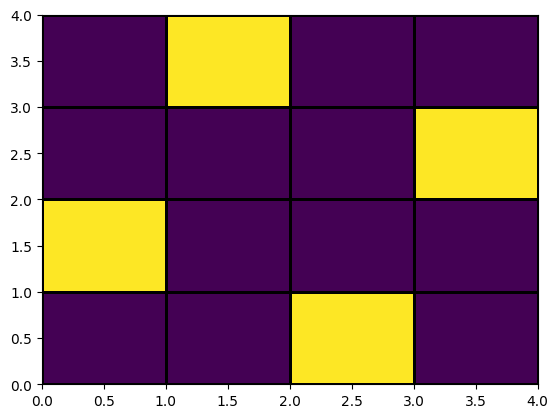

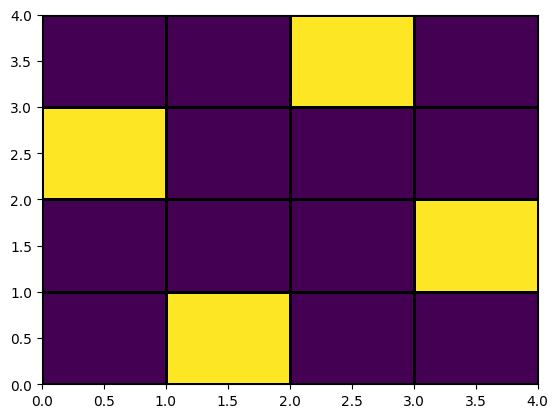

In [31]:
for i in range(len(best_solutions)):
    get_board_from_row(mapping, best_solutions.iloc[i])

---

# QAOA

In [6]:
def get_obs(total_qubits:int, qubits:List[int]) -> str:
    obs = ['I']*total_qubits
    for qubit in qubits:
        obs[-(qubit+1)] = 'Z'
    return ''.join(obs)

In [7]:
Params = List[float]
History = List[float]
def cost_func(params:Params, ansatz:QuantumCircuit, hamiltonian:SparsePauliOp, estimator:EstimatorV2, history:History) -> float:
    """Get the cost of the current circuit"""
    isa_h = hamiltonian.apply_layout(ansatz.layout)
    
    job = estimator.run([(ansatz, isa_h, params)])

    results = job.result()[0]
    cost = abs(results.data.evs)

    history.append(cost)
    print("Current cost: ", cost)

    return [cost]

In [8]:
TermsList = List[str|int]
ObsTerms = Dict[str,float]
def terms_product(terms1:TermsList, terms2:TermsList, total_qubits:int) -> ObsTerms:
    obs_terms = defaultdict(float)

    obs_constant = get_obs(total_qubits, [])

    for x0,x1 in product(terms1, terms2):
        
        x0_is_int = isinstance(x0, int)
        x1_is_int = isinstance(x1, int)

        if not x0_is_int and not x1_is_int:
            obs = get_obs(total_qubits, [int(x0)] if x0 == x1 else [int(x0), int(x1)])
            obs_terms[obs] += 1

        elif x0_is_int and not x1_is_int:
            obs = get_obs(total_qubits, [int(x1)])
            obs_terms[obs] += x0

        elif not x0_is_int and x1_is_int:
            obs = get_obs(total_qubits, [int(x0)])
            obs_terms[obs] += x1
        
        else:
            obs_terms[obs_constant] += x0 * x1

    return obs_terms

In [ ]:
def get_H(mapping:Mapping, P:int) -> SparsePauliOp:
    total_qubits = N*N
    terms = defaultdict(float)

    constant_obs = get_obs(total_qubits, []) 

    # first part - adding the quadratic terms
    term_coeff = 0.25
    for i in range(N):
        for j in range(N):
            pos = (i,j) # (row, column)
            current_pos_qubit = mapping[pos]

            attacks = get_attacks_for_each_cell(pos)


            for attack in attacks:
                attack_qubit = mapping[attack]
                
                attack_obs = get_obs(total_qubits, [current_pos_qubit, attack_qubit])
                ind_1_obs = get_obs(total_qubits, [current_pos_qubit])
                ind_2_obs = get_obs(total_qubits, [attack_qubit])

                #terms[constant_obs] += term_coeff
                terms[attack_obs] += term_coeff
                terms[ind_1_obs] += term_coeff
                terms[ind_2_obs] += term_coeff

    

    for qubit in range(total_qubits):
        obs = get_obs(total_qubits, [qubit])
        terms[obs] += -P*N
    

    penality_terms = list(map(str, list(range(total_qubits))))
    mapped_terms = terms_product(penality_terms, penality_terms, total_qubits)
    for term,value in mapped_terms.items():
        if(term == constant_obs):
            continue

        terms[term] += P*0.25
    
    #terms[constant_obs] += P*N*N


    return SparsePauliOp.from_list(terms.items())
    



In [11]:
mapping = get_pos_mapping()

hamiltonian = get_H(mapping, N*N)
hamiltonian

SparsePauliOp(['IIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIZIIIZ', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIIZII', 'IIIIIIIZIIIIIIIZ', 'IIIIIIIZIIIIIIII', 'IIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIIZIII', 'IIIZIIIIIIIIIIIZ', 'IIIZIIIIIIIIIIII', 'IIIIIIIIIIZIIIIZ', 'IIIIIIIIIIZIIIII', 'IIIIIZIIIIIIIIIZ', 'IIIIIZIIIIIIIIII', 'ZIIIIIIIIIIIIIIZ', 'ZIIIIIIIIIIIIIII', 'IIIIIIIIIIZIIIZI', 'IIIIIIIIIIIIIZZI', 'IIIIIIZIIIIIIIZI', 'IIIIIIZIIIIIIIII', 'IIIIIIIIIIIIZIZI', 'IIZIIIIIIIIIIIZI', 'IIZIIIIIIIIIIIII', 'IIIIIIIIIZIIIIZI', 'IIIIIIIIIZIIIIII', 'IIIIZIIIIIIIIIZI', 'IIIIZIIIIIIIIIII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIZIIIZII', 'IIIIIZIIIIIIIZII', 'IIIIIIIIIIIIZZII', 'IZIIIIIIIIIIIZII', 'IZIIIIIIIIIIIIII', 'IIIIIIIIZIIIIZII', 'IIIIIIIIZIIIIIII', 'IIIIIIIIIIZIIZII', 'IIIIIIIZIIIIIZII', 'IIIIIIIIZIIIZIII', 'IIIIZIIIIIIIZIII', 'ZIIIIIIIIIIIZIII', 'IIIIIIIIIZIIZIII', 'IIIIIIZIIIIIZIII', 'IIIZIIIIIIIIZIII', 'IIIIIIIIIIZZIIII', 'IIIIIIIIIZIZIIII', 'IIII

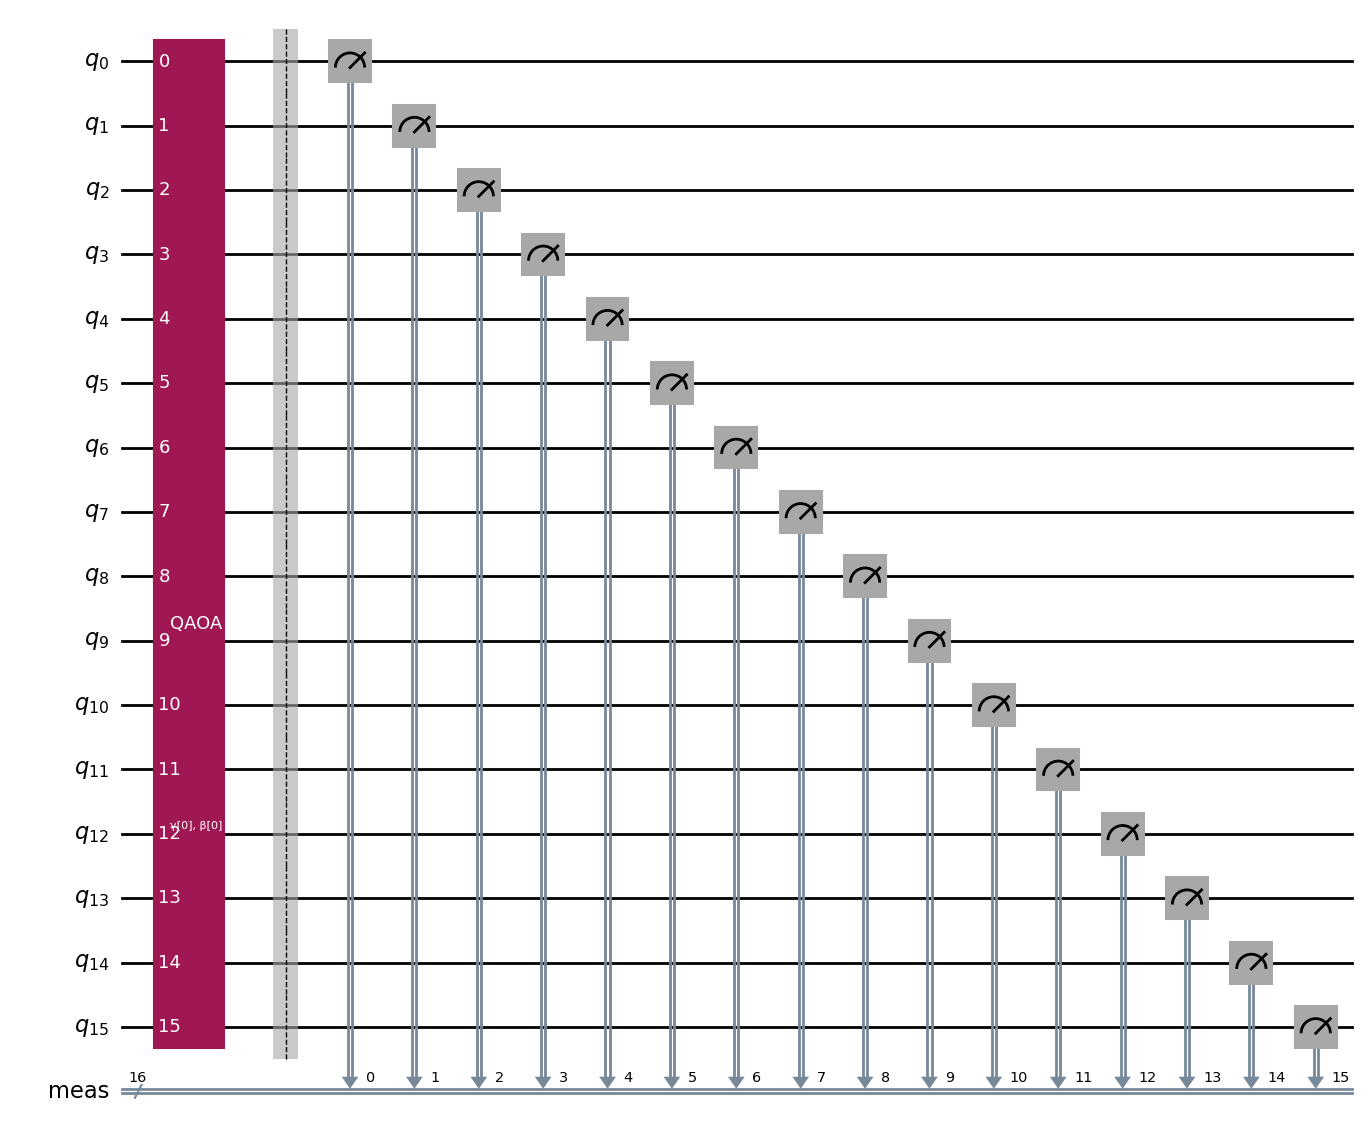

In [12]:

qaoa = QAOAAnsatz(cost_operator=hamiltonian,reps=1)
qaoa.measure_all()
qaoa.draw('mpl')

In [ ]:
sim = AerSimulator()
pm = generate_preset_pass_manager(optimization_level=0, backend=sim)
isa_qc = pm.run(qaoa)

history = []
estimator = EstimatorV2()
init_params = [np.random.uniform(low=0.0, high=(int(i%2==0)+1)*np.pi, size=1)[0] for i in range(len(isa_qc.parameters))]
print(init_params)
result = minimize(
        cost_func,
        init_params,
        args=(isa_qc, hamiltonian, estimator, history),
        method="COBYLA",
        bounds=[ (0,(int(i%2==0)+1)*np.pi) for i in range(len(isa_qc.parameters)) ],
        tol=1e-3,
    )

[np.float64(0.3724066239717468), np.float64(1.7716202022476402)]
Current cost:  304.162109375
Current cost:  298.837890625
Current cost:  287.732421875
Current cost:  287.923828125
Current cost:  302.955078125
Current cost:  324.02734375
Current cost:  317.126953125
Current cost:  351.29296875
Current cost:  291.126953125
Current cost:  327.947265625
Current cost:  424.716796875
Current cost:  283.982421875
Current cost:  485.091796875
Current cost:  146.537109375
Current cost:  316.462890625
Current cost:  212.751953125
Current cost:  135.396484375
Current cost:  160.708984375
Current cost:  164.4140625
Current cost:  138.6953125
Current cost:  143.02734375


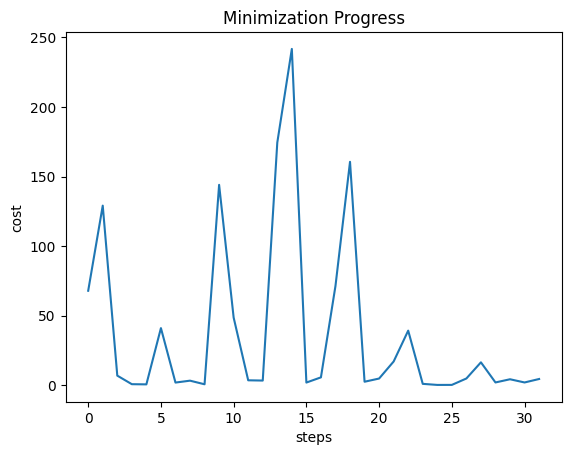

In [50]:
plt.title("Minimization Progress")
plt.plot(list(range(len(history))), history)
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

In [51]:
print(result.x)
answer_qc = isa_qc.assign_parameters(result.x)

[2.85790585 3.14152712]


In [52]:
sampler = SamplerV2()
job = sampler.run([answer_qc], shots=1000)
bit_strings = job.result()[0].data.meas.get_counts()
bit_strings

{'0010001011111111': 1,
 '1010000110110011': 1,
 '0010100110011111': 1,
 '1111111011010001': 1,
 '1101011100000011': 1,
 '0110011110000010': 1,
 '1110010001101110': 1,
 '1000010100111001': 1,
 '0101010100110101': 1,
 '1110100001111010': 1,
 '0000011010111100': 1,
 '0100011011001110': 1,
 '0111010100000011': 1,
 '1000110100110001': 1,
 '1000110010110101': 1,
 '1011101100110110': 1,
 '1001001111001101': 1,
 '0110000000001000': 1,
 '0110101110101111': 1,
 '0010101101110101': 1,
 '0011000110111110': 1,
 '0101100010001110': 1,
 '0101000101101100': 1,
 '1001010110101100': 1,
 '1101101000100011': 1,
 '1110001111001101': 1,
 '1100100101101101': 1,
 '1100110010111000': 1,
 '0010001000010010': 1,
 '1100011010111111': 1,
 '0110000111001001': 1,
 '0101001101011011': 1,
 '1011000111111010': 1,
 '1101100111111001': 1,
 '1111111011110000': 1,
 '1110101010011011': 1,
 '0011110111111001': 1,
 '0111000100011001': 1,
 '0001000111100001': 1,
 '0101111110000111': 1,
 '1111100010100011': 1,
 '01001001100110

In [53]:
def solution_board(bit_string:str):
    matrix = []

    qubit = 0
    for i in range(N):
        matrix.append([])
        for j in range(N):
            matrix[-1].append(int(bit_string[qubit]))
            qubit += 1
    
    plt.pcolormesh(matrix,edgecolors="k",linewidth=2)
    plt.show()

1101011101110000


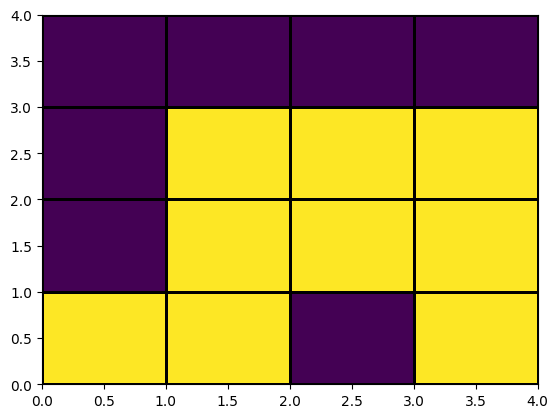

In [54]:
best_solution = max(bit_strings.items(), key=lambda x: x[-1])[0]
print(best_solution)
solution_board(best_solution)